# Tutorial on EAM regression

How to set up and perform EAM regressions using PottyTrainer.

Note, EAM regression is currently implemented via the python modules scoop: http://scoop.readthedocs.io/en/0.7/usage.html and deap: https://deap.readthedocs.io/en/master/ . On windows it is recommended to install pyzmq first.

In [1]:
from __future__ import print_function
import itertools, copy
import numpy as np
from scipy import stats

import parsers
import fitelectrondensity as fed
from fitelectrondensity.linear_model import RelevanceVectorMachine, distribution_wrapper
import fitenergy as fe
from fitenergy.regression import calculator

import numpy as np

%matplotlib notebook
import matplotlib.pylab as plt

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


## 1. Regress electrondensities

### Parse DFT files and set up the Design Matrix

In [2]:
# info loading from disk
dft_path = "./tests/unittest_files/EAM_test_Al-Ni/few/"

# info for bonds
num_neigh = None # number of neighoring atoms for (ghost) atom
r_cut = 6.
aniso = False
ultra_num = None #number of additional super cells in each sim box vector direction
selection=("atom",.5,"r") # first tuple entry specifies selection type, following fix specifics, i.e.("random",10.) mean select 10% of all points uniformly at random 
seed = None
np.random.seed(seed=seed)

# info for basis set
k_iso=25 # parameter for iso basis size
type_iso="Fourier" # type of basis for iso
smooth = True # apply smoothing of basis functions towards r_smooth
r_smooth = r_cut # functions smoothed out / tapered to 0 toward r_smooth
r_scale = r_cut # scaling value for pair distances (relevant value depends chosen features)
self_contribution = False # whether or not an atom itself is considered contribution to the valence elenctron density
f_smooth = .1 # fudge factor for smoothing
usefortran = False

# parsing DFT files
print("\nparsing DFT files...")
gip = parsers.general.GeneralInputParser(verbose=False)
gip.parse_all(dft_path)
gip.sort()
print("done")

print("\nsetting up bonds...")
bonds = []
for g in gip:
    print("\nprocessing: {}".format(g.get_name()))
    _bonds = fed.misc.get_observations(g,ultra_num=ultra_num,num_neigh=num_neigh,
                                       r_cut=r_cut,aniso=aniso,verbose=False,
                                       selection=selection,seed=seed,usefortran=usefortran)
    bonds.extend(_bonds)

# shifting electron densities to be all positive    
bonds, _ = fed.misc.shift_densities(bonds,verbose=False)
print("done")

# get basis
print("\nsetting up basis and mapper...")
basis, mapper = fed.rvm.get_basis([gip],k_iso=k_iso,type_iso=type_iso,
                                  smooth=smooth,r_smooth=r_smooth,f_smooth=f_smooth,
                                  verbose=False,self_contribution=self_contribution,rcut=r_cut,
                                  aniso=aniso,r_scale=r_scale)
print("done")

# get design matrix
print("\nsetting up design matrix and target vector...")
Phi, t = fed.rvm.get_design_matrix(bonds,basis,mapper,verbose=False,return_t=True,seed=seed,usefortran=usefortran)
print("design matrix dimension = {} x {}".format(Phi.shape[0],Phi.shape[1]))
print("done")


parsing DFT files...
done

setting up bonds...

processing: A1_a_0
Found all cells for r_cut 6.0 => r_search = 14.20 Ang, terminating after 7 iterations

processing: A1_a_1


E:\PetProjects\Empirical Potentials\PottyTrainer\pottytrainer\fitelectrondensity\misc.py:398: RuntimeWarning: invalid value encountered in true_divide
  r_vec /= np.reshape(r["all"],(-1,1))


Found all cells for r_cut 6.0 => r_search = 14.21 Ang, terminating after 7 iterations

processing: AlNi_ICSD_58038_a_0
Found all cells for r_cut 6.0 => r_search = 13.58 Ang, terminating after 4 iterations

processing: AlNi_ICSD_58038_a_1
Found all cells for r_cut 6.0 => r_search = 13.58 Ang, terminating after 4 iterations

processing: Ni_A1_a2_0
Found all cells for r_cut 6.0 => r_search = 13.54 Ang, terminating after 7 iterations

processing: Ni_A1_a2_1
Found all cells for r_cut 6.0 => r_search = 13.55 Ang, terminating after 7 iterations

processing: Ni_A1_a2_2
Found all cells for r_cut 6.0 => r_search = 13.55 Ang, terminating after 7 iterations
done

setting up basis and mapper...
done

setting up design matrix and target vector...
Generating design matrix for 934 samples...
mapping >> s Al, ix_s 0, ix_e 25
mapping >> s Ni, ix_s 25, ix_e 50
design matrix dimension = 934 x 50
done


### Initializing priors and Performing RVM regression

In [4]:
# RVM initiate hyper parameters
niter = 300
tol = 1e-3
fix_beta = False
n_steps_beta = 1 # integer specifying every nth step to update beta
sequential = False
niter_stochastic = 1 # number of iterations generating new Phis according to variable 'stochastic' if stochastic[0] != "all"

# initialize priors
N, M = Phi.shape
## manually fixed
# alphas_init = np.ones(M)
# alphas_init[1:] = np.inf # default
# beta_init = 1./np.var(t) # default
## randomly drawn (useful for repetitions to check for regression convergence behavior)
beta_init = distribution_wrapper(stats.halfnorm(scale=1),size=1,single=True)
alphas_init = distribution_wrapper(stats.halfnorm(scale=1),single=False)

print("regressing...")
## old version
# logbook = fed.rvm.iterate(Phi,t,niter=niter,verbose=False,alpha_init=alpha_init,beta_init=beta_init,tol=tol,
#                           fix_beta=fix_beta,sequential=sequential,n_steps_beta=n_steps_beta,seed=seed)
## new version
model = RelevanceVectorMachine(n_iter=niter,init_alphas=alphas_init,init_beta=beta_init,compute_score=True,
                               do_logbook=True,fit_intercept=False,verbose=False,tol=tol, update_pct=.9)
model.fit(Phi,t.ravel())
logbook = model.get_logbook()
print("done")

regressing...
done


### Plotting and storing data in a *.rhos file for EAM regression

<IPython.core.display.Javascript object>


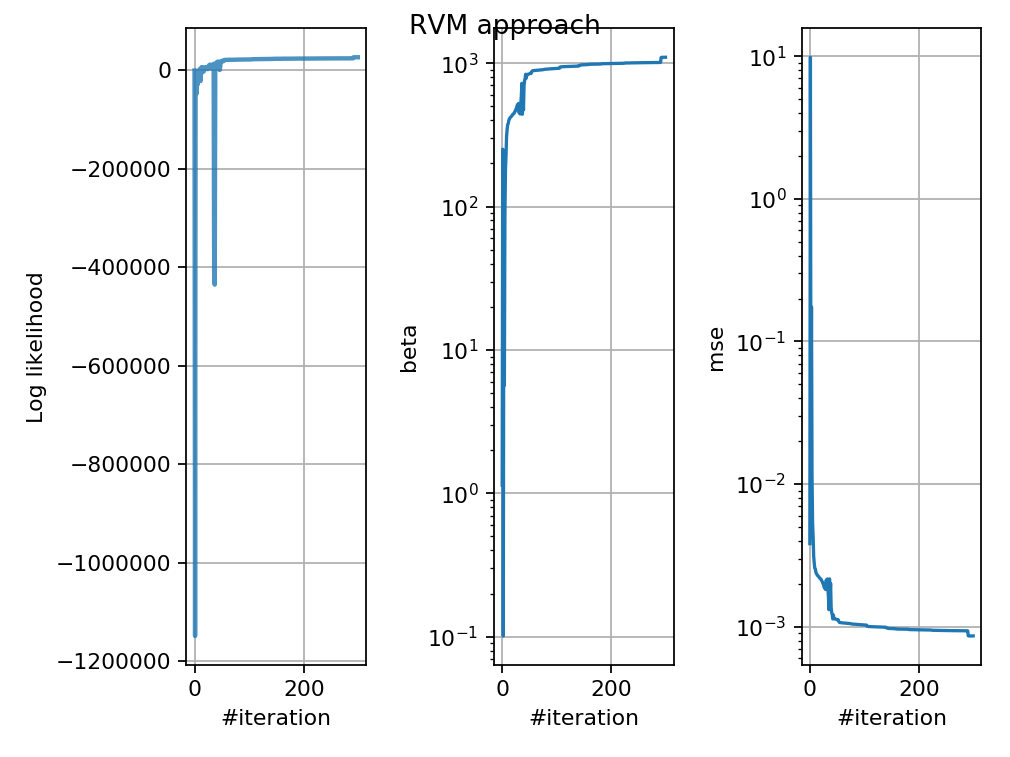

Selected iteration 298 for output:
L = 26878.620903651725, mse = 0.0008601294319498558, tse = 0.8033608894411653
Calculating isotropic rhos: N_steps = 10000, r_smooth = 6.0, incrementing by 0.0006 up to 5.9994...


<IPython.core.display.Javascript object>


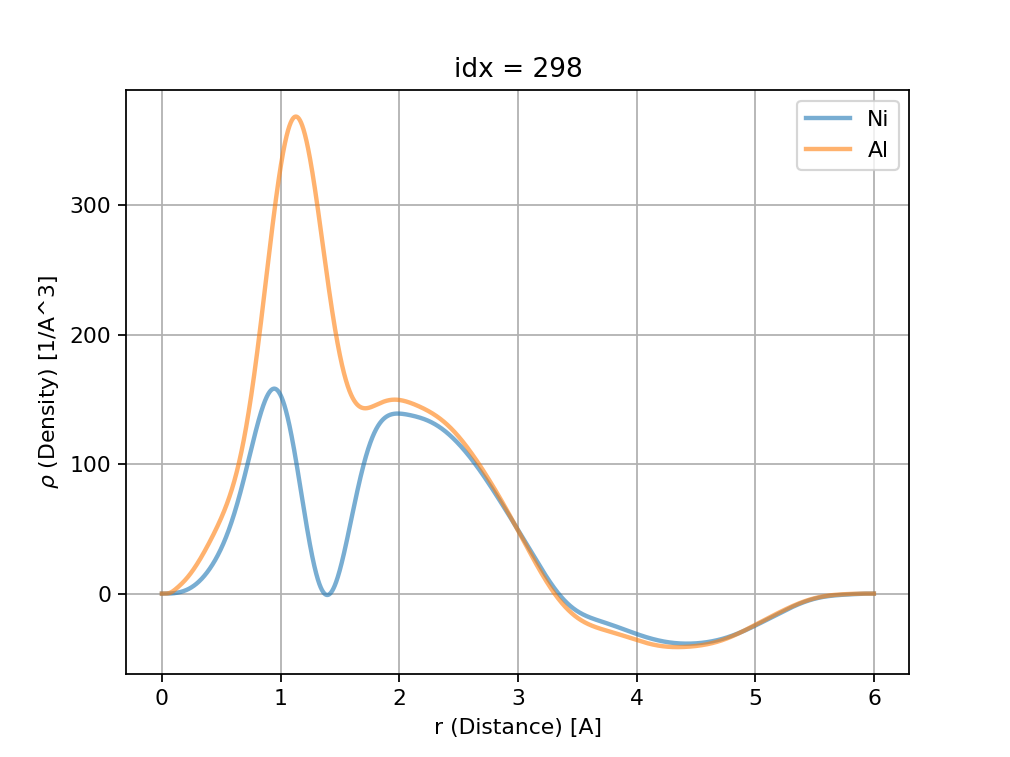

Saving the regression data to ./tests/unittest_files/EAM_test_Al-Ni/Al-Ni.rhos...


In [5]:
Nsteps_iso = 10000 #number of steps to to plot rho(r) from r = 0 to r = r_smooth
save_path_rhos = "./tests/unittest_files/EAM_test_Al-Ni/Al-Ni.rhos"

# some plotting - performance
fed.misc.show_rvm_performance(niter,logbook) # likelihood and beta vs iteration

# select weights according to some criterion
idx = np.nanargmin(logbook["tse"])
print("Selected iteration {} for output:\nL = {}, mse = {}, tse = {}".format(idx,logbook["L"][idx],logbook["mse"][idx],logbook["tse"][idx]))
weights = logbook["weights_full"][idx]

# plotting rho(r)
r, rhos = fed.predict.predict_rho_iso(mapper,weights,basis,r_smooth,Nsteps_iso)
fed.misc.show_rho_iso(r,rhos,title="idx = {}".format(idx)) # rho(r)

# saving final rhos to disk 
fed.misc.save_regressed_rho(r,rhos,save_path_rhos,lb=0,ub=r_smooth,dft_path=dft_path,logbook=logbook,i=idx,
                            niter=niter,tol=tol,fix_beta=fix_beta,sequential=sequential,
                            k_iso=k_iso,type_iso=type_iso,ultra_num=ultra_num,selection=selection,
                            num_neigh=num_neigh,r_cut=r_cut,aniso=aniso,smooth=smooth,r_smooth=r_smooth,
                            f_smooth=f_smooth,weights=weights)

## 2. Preparing an EAM regression

This bit does all the parsing and pre-calculations the fitting process in
the next step depends on. If there are $n$ elements in all the provided atomic models
then the following cell will generate $n+1$ *.pckl files containing information for the 
regression of each individual element followed by regression over all elements.

Given EAM setup variables:
N_steps:    100000
aniso:    False
dft_path:    ./tests/unittest_files/EAM_test_Al-Ni/few/
dump_fname:    setup_plain_normed
dump_path:    ./tests/unittest_files/EAM_test_Al-Ni/
f_smooth:    0.01
f_smooth_emb:    0.01
k_emb:    10
k_pair:    10
load_path_rhos:    ./tests/unittest_files/EAM_test_Al-Ni/Al-Ni.rhos
num_neigh:    None
r_cut:    6.0
r_lb:    0.0
r_smooth:    6.0
r_ub:    6.0
return_rho_bounds:    True
rho_conv_type:    psi
rho_operations:    ['shift']
rho_params:    [6.0, 2.0]
rho_scaling:    1.0
save:    True
seed:    None
selection:    [('A', 'all'), ('Ni', 'all')]
show:    True
smooth_emb:    True
smooth_pair:    True
split2groups:    True
type_emb:    Fourier
type_pair:    Fourier
ultra_num:    None
Sanity checking setup vars...
Loading regression data from ./tests/unittest_files/EAM_test_Al-Ni/Al-Ni.rhos...


<IPython.core.display.Javascript object>


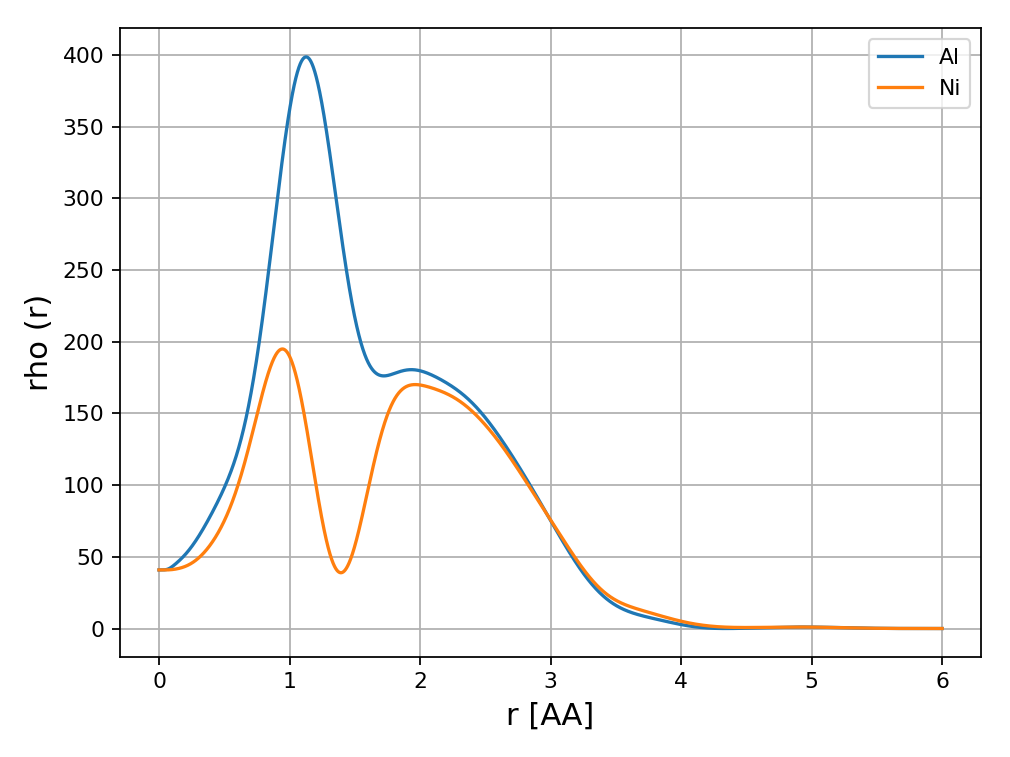

Selecting using [('A', 'all'), ('Ni', 'all')]
idx [0, 1, 2, 3, 4, 5, 6]
selected structures for fitting: ['A1_a_0', 'A1_a_1', 'AlNi_ICSD_58038_a_0', 'AlNi_ICSD_58038_a_1', 'Ni_A1_a2_0', 'Ni_A1_a2_1', 'Ni_A1_a2_2']
idx [0, 1, 2, 3, 4, 5, 6]


E:\PetProjects\Empirical Potentials\PottyTrainer\pottytrainer\fitenergy\__init__.py:797: UserWarning: Splining is done using the 'extrapolate' value for the fill_value parameter! This may cause problems, check for adequate cutoff and smoothing settings.
  if fill_value == "extrapolate": warnings.warn("Splining is done using the 'extrapolate' value for the fill_value parameter! This may cause problems, check for adequate cutoff and smoothing settings.")


Found all cells for r_cut 6.0 => r_search = 14.20009663539376, terminating after 7 iterations

name A1_a_0
energy -110.8720907127
ref -107.516326115032 elements ['Al']
e_form -3.3557645976679993
Found all cells for r_cut 6.0 => r_search = 14.20666238145917, terminating after 7 iterations

name A1_a_1
energy -110.872883603
ref -107.516326115032 elements ['Al']
e_form -3.3565574879680042
Found all cells for r_cut 6.0 => r_search = 13.57785990766018, terminating after 4 iterations

name AlNi_ICSD_58038_a_0
energy -1050.04958119675
ref -1045.415141059258 elements ['Al', 'Ni', 'Ni', 'Ni']
e_form -4.634440137491993
Found all cells for r_cut 6.0 => r_search = 13.5836401076152, terminating after 4 iterations

name AlNi_ICSD_58038_a_1
energy -1050.05127099325
ref -1045.415141059258 elements ['Al', 'Ni', 'Ni', 'Ni']
e_form -4.636129933991924
Found all cells for r_cut 6.0 => r_search = 13.539407408307465, terminating after 7 iterations

name Ni_A1_a2_0
energy -1362.496837795
ref -1358.048079374 e

E:\PetProjects\Empirical Potentials\PottyTrainer\pottytrainer\fitenergy\potential_serial.py:210: UserWarning: Splining is done using the 'extrapolate' value for the fill_value parameter! This may cause problems, check for adequate cutoff and smoothing settings.
  if fill_value == "extrapolate": warnings.warn("Splining is done using the 'extrapolate' value for the fill_value parameter! This may cause problems, check for adequate cutoff and smoothing settings.")


In [6]:
seed = None

#### IO 
# source
dft_path = "./tests/unittest_files/EAM_test_Al-Ni/few/" # dir with DFT files for regresson
selection=[("A","all"),("Ni","all")] # selection criteria for DFT calcs
split2groups = True # splits the selected group of dft structures into subgroups, i.e. when containing Al and Ni the groups are Al only, Ni only and Ni-Al only (no pure structures)
save = True # EAM_setup: if True data for regression will be written to disk as *.pickl file(s), otherwise it will be returned

# path to file which contains results from edensity regression
load_path_rhos = "./tests/unittest_files/EAM_test_Al-Ni/Al-Ni.rhos"

# target
dump_path = "./tests/unittest_files/EAM_test_Al-Ni/"
dump_fname = "setup_plain_normed" # suffix will be ".pckl", if it's not present it will be added (ending on 0 means no forcing rho->0 for r=0, ending on 1 means forcing rho->0 for r=0)

#### settings
# info for bonds
num_neigh = None # number of neighoring atoms for (ghost) atom
r_cut = 6.

# info for basis set
k_pair = 10 # parameter for basis size of pair energy functions
k_emb = 10 # parameter for basis size of embedding energy functions
smooth_emb = True
smooth_pair = True 
type_pair="Fourier" # type of basis for pair energy functions
type_emb="Fourier" # type of basis for embedding energy functions
r_smooth = 6.
f_smooth = .01 # fudge factor for smoothing distances
f_smooth_emb = .01 # fudge factor for smoothing embedding densities
rho_scaling = 1.

# info for EAM
r_lb=0.
r_ub=float(r_cut)

return_rho_bounds = True
rho_conv_type = "psi" #"psi" #"psi" #"psi2" (shifted + smoothed to 0 in two points), "psi" (shifted + smoothed to zero in one point), None (no smoothing)
rho_operations = ["shift"]#["absolute","normalize"]
rho_params = [r_cut,2.]#,0,.25] # parameters for the convolution of rho functions
N_steps = 100000

# stuffing all variables into a dict which can be passed more easily
setup_vars = {"dft_path":dft_path,"selection":selection,"split2groups":split2groups,"save":save,"load_path_rhos":load_path_rhos,
              "dump_path":dump_path,"dump_fname":dump_fname,"num_neigh":num_neigh,"r_cut":r_cut,"k_pair":k_pair,
              "k_emb":k_emb,"smooth_emb":smooth_emb,"smooth_pair":smooth_pair,"type_pair":type_pair,"type_emb":type_emb,
              "r_smooth":r_smooth,"f_smooth":f_smooth,"f_smooth_emb":f_smooth_emb,"rho_scaling":rho_scaling,"r_lb":r_lb,
              "r_ub":r_ub,"return_rho_bounds":return_rho_bounds,"rho_operations":rho_operations,"rho_params":rho_params,
              "N_steps":N_steps,"rho_conv_type":rho_conv_type,}

_ = fe.EAM_setup(show=True,**setup_vars)

## 3. EAM regression - of a Single Element

EAM potentials for __single elements__ can be obtained using 'EAM_fit_single_element.py' in the command line as: 

`python -m scoop EAM_fit_single_element.py`

Note that you open that script and modify the section after `if __name__ == "__main__"`. Each execution of `EAM_fit_single_element.py` regresses only the element as specified by the path in the script with parameter `fit_data_load_path`. Results of the regression will be written to *.Es files specified by `template_save_Es_path`.

## 4. EAM Regression of Multiple Elements

Once the regression of EAM potentials is done for each individual element such that all $E_{\text{pair,like}}$ are known one can start developing $E_{\text{emb}}$ and $E_{\text{pair,unlike}}$ for the full potentials. This is done similarly using 'EAM_fit_multiple_elements.py' in the command line as: 

`python -m scoop EAM_fit_multiple_elements.py`

Note that you open that script and modify the section after `if __name__ == "__main__"`.

However, before `EAM_fit_multiple_elements.py` can be executed we should select our preferred weights of the single elements on which the multi element potential will be built. One way this can be done is by selecting weights according to their fitness as shown below. Similarly as for the single element EAM optimization the results of the regression will be written to *.Es files specified by `template_save_Es_path`.

Loading data from tests/unittest_files/EAM_test_Al-Ni/Al_plain_normed_1.Es...
Loading data from tests/unittest_files/EAM_test_Al-Ni/Al_plain_normed_0.Es...
Loading data from tests/unittest_files/EAM_test_Al-Ni/Ni_plain_normed_0.Es...
Loading data from tests/unittest_files/EAM_test_Al-Ni/Ni_plain_normed_1.Es...


<IPython.core.display.Javascript object>


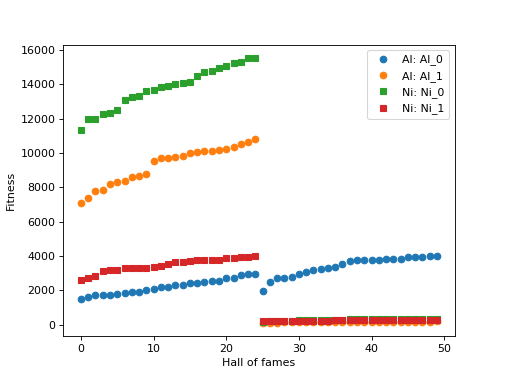

5 best candidates each:
Al
[0 1 2 3 4]
Al_0: 0: 1.5e+03, 1: 1.6e+03, 2: 1.7e+03, 3: 1.7e+03, 4: 1.7e+03
[25 26 27 28 29]
Al_1: 25: 86, 26: 1.2e+02, 27: 1.2e+02, 28: 1.2e+02, 29: 1.3e+02

Ni
[25 26 27 28 29]
Ni_0: 25: 1.2e+02, 26: 1.8e+02, 27: 2e+02, 28: 2e+02, 29: 2.1e+02
[25 26 27 28 29]
Ni_1: 25: 1.8e+02, 26: 2e+02, 27: 2e+02, 28: 2e+02, 29: 2.1e+02


In [7]:
path_Als = {"Al_0":r"tests/unittest_files/EAM_test_Al-Ni/Al_plain_normed_0.Es",
            "Al_1":r"tests/unittest_files/EAM_test_Al-Ni/Al_plain_normed_1.Es",}
path_Nis = {"Ni_0":r"tests/unittest_files/EAM_test_Al-Ni/Ni_plain_normed_0.Es",
             "Ni_1":r"tests/unittest_files/EAM_test_Al-Ni/Ni_plain_normed_1.Es",}
datas_Al = {k:fe.load_data(path) for k,path in path_Als.items()}
datas_Ni = {k:fe.load_data(path) for k,path in path_Nis.items()}

fig = plt.figure()
ax = fig.add_subplot(111)
for k in datas_Al:
    ax.plot(np.array(datas_Al[k]["all_fitnesses"]).ravel(),'o',label="Al: {}".format(k))
for k in datas_Ni:
    ax.plot(np.array(datas_Ni[k]["all_fitnesses"]).ravel(),'s',label="Ni: {}".format(k))
ax.set_xlabel("Hall of fames")
ax.set_ylabel("Fitness")
plt.legend(loc=0)
plt.show()

n_candidates = 5
print("{} best candidates each:\nAl".format(n_candidates))
for k in sorted(datas_Al):
    idx = np.argsort(np.array(datas_Al[k]["all_fitnesses"]).ravel())[:n_candidates]
    print(idx)
    print("{}:".format(k),", ".join(["{}: {:.2g}".format(v,datas_Al[k]["all_fitnesses"][v][0]) for v in idx]))
print("\nNi")
for k in sorted(datas_Ni):
    idx = np.argsort(np.array(datas_Ni[k]["all_fitnesses"]).ravel())[:n_candidates]
    print(idx)
    print("{}:".format(k),", ".join(["{}: {:.2g}".format(v,datas_Ni[k]["all_fitnesses"][v][0]) for v in idx]))

Similarly we can find the weights with the best best fitnesses for complete potentials.

Loading data from tests/unittest_files/EAM_test_Al-Ni/plain_normed_glipglobs_Al-1-0_Ni-0-25_1.Es...
Loading data from tests/unittest_files/EAM_test_Al-Ni/plain_normed_glipglobs_Al-1-0_Ni-0-25_0.Es...


<IPython.core.display.Javascript object>


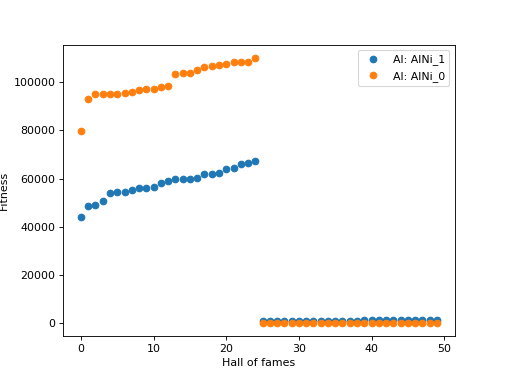

5 best candidates each:
Al
[25 26 27 28 29]
AlNi_0: 25: 6, 26: 7.8, 27: 9.3, 28: 17, 29: 18
[25 26 27 28 29]
AlNi_1: 25: 6.6e+02, 26: 8e+02, 27: 8.3e+02, 28: 8.9e+02, 29: 8.9e+02


In [8]:
path_glipglobs = {"AlNi_0":r"tests/unittest_files/EAM_test_Al-Ni/plain_normed_glipglobs_Al-1-0_Ni-0-25_0.Es",
                  "AlNi_1":r"tests/unittest_files/EAM_test_Al-Ni/plain_normed_glipglobs_Al-1-0_Ni-0-25_1.Es",}
datas_glipglobs = {k:fe.load_data(path) for k,path in path_glipglobs.items()}

fig = plt.figure()
ax = fig.add_subplot(111)
for k in datas_glipglobs:
    ax.plot(np.array(datas_glipglobs[k]["all_fitnesses"]).ravel(),'o',label="Al: {}".format(k))

ax.set_xlabel("Hall of fames")
ax.set_ylabel("Fitness")
plt.legend(loc=0)
plt.show()

n_candidates = 5
print("{} best candidates each:\nAl".format(n_candidates))
for k in sorted(datas_glipglobs):
    idx = np.argsort(np.array(datas_glipglobs[k]["all_fitnesses"]).ravel())[:n_candidates]
    print(idx)
    print("{}:".format(k),", ".join(["{}: {:.2g}".format(v,datas_glipglobs[k]["all_fitnesses"][v][0]) for v in idx]))

### Generating an instance of the ase EAM calculator class

Loading data from tests/unittest_files/EAM_test_Al-Ni/plain_normed_glipglobs_Al-1-0_Ni-0-25_1.Es...
Loading data from ./tests/unittest_files/EAM_test_Al-Ni/setup_plain_normed_glipglobs.pckl...


<IPython.core.display.Javascript object>


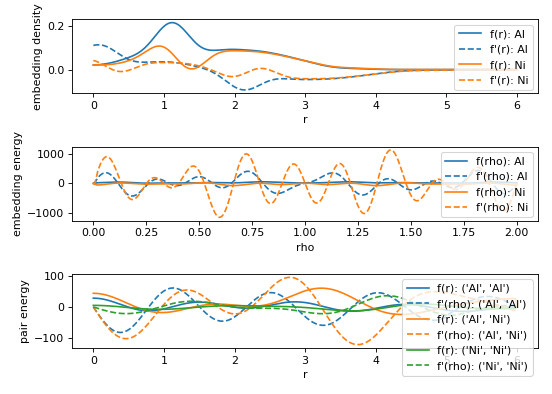

<IPython.core.display.Javascript object>


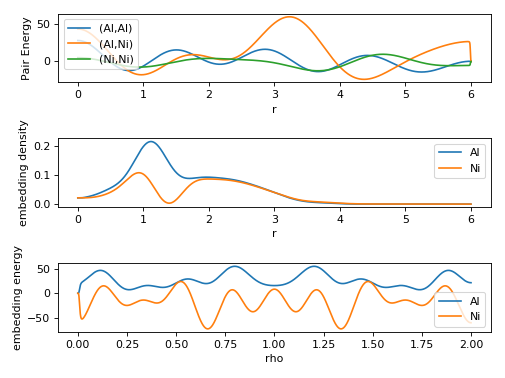

In [9]:
# choosing the parameterization
idx = 25 # index for the weight to choose
weights = datas_glipglobs["AlNi_1"]["all_weights"][idx]

# generating the EAM calculator instance
Es_path = "tests/unittest_files/EAM_test_Al-Ni/plain_normed_glipglobs_Al-1-0_Ni-0-25_1.Es"

Es = fe.load_data(Es_path)
data = fe.load_data(Es["fit_data_load_path"])

needed_vars = ["smooth_emb","smooth_pair","f_smooth_emb","f_smooth","r_smooth","rho_lb","rho_ub",
         "N_steps","rho_scaling","mapper","r_lb","r_ub","rho_dict","r_cut"]

params = dict()
for n in needed_vars:
    try:
        params[n] = Es[n]
    except:
        params[n] = data[n]

_params = copy.deepcopy(params)
mapper = _params.pop("mapper")
rho_dict = _params.pop("rho_dict")
rho_lb = _params.pop("rho_lb")
rho_ub = _params.pop("rho_ub")

# number of basis functions for each pair and embedding energy function
Mr, Mrho = len(list(mapper["pair"].values())[0]), len(list(mapper["pair"].values())[0])

# basis functions
kappa_r = np.arange(Mr) * np.pi / params["r_cut"]
kappa_rho = np.arange(Mrho) * np.pi / params["rho_scaling"]
taper_fun_r = fe.taper_fun_wrapper(_type="x4ge",a=params["r_cut"],b=params["f_smooth"])
taper_fun_emb = fe.taper_fun_wrapper(_type="x4le",a=0,b=params["f_smooth_emb"])

basis_r = [fe.DistanceCosTapering_basis(_kappa_r,taper_fun_r) \
           for _kappa_r in kappa_r]
basis_rho = [fe.DistanceCosTapering_basis(_kappa_rho,taper_fun_emb) \
             for _kappa_rho in kappa_rho]
basis_r_1stder = [fe.DistanceCosTapering_basis_1stDerivative(_kappa_r,taper_fun_r) \
           for _kappa_r in kappa_r]
basis_rho_1stder = [fe.DistanceCosTapering_basis_1stDerivative(_kappa_rho,taper_fun_emb) \
           for _kappa_rho in kappa_rho]

# energy functions
energy_functions = fe.get_splined_energy_functions(params["mapper"], weights, params["rho_lb"],\
                                                params["rho_ub"], params["rho_dict"], basis_r,\
                                                basis_rho, basis_r_1stder=basis_r_1stder,\
                                                basis_rho_1stder=basis_rho_1stder, show=True, figsize=(7,5), **_params)

# creating an ase EAM calculator instance
eam_pot = fe.generate_EAM_calculator(energy_functions, N_steps=params["N_steps"],
                                  r_cut=params["r_cut"])

# plotting the EAM functions
fig = plt.figure()
r = np.linspace(0,eam_pot.nr*eam_pot.dr,eam_pot.nr)
rho = np.linspace(0,eam_pot.nrho*eam_pot.drho,eam_pot.nrho)

# pair energy
ax = fig.add_subplot(311)
Nele = len(eam_pot.elements)
for i,j in itertools.product(range(Nele),range(Nele)):
    if i<=j:
        E = eam_pot.phi[i,j](r)
        ax.plot(r,E,label="({},{})".format(eam_pot.elements[i],eam_pot.elements[j]))
plt.legend(loc=0)
ax.set_xlabel("r")
ax.set_ylabel("Pair Energy")

ax1 = fig.add_subplot(312)
for i in range(Nele):
    dens = eam_pot.electron_density[i](r)
    ax1.plot(r,dens,label=eam_pot.elements[i])
ax1.set_xlabel("r")
ax1.set_ylabel("embedding density")
plt.legend(loc=0)

ax2 = fig.add_subplot(313)
for i in range(Nele):
    E = eam_pot.embedded_energy[i](rho)
    ax2.plot(rho,E,label=eam_pot.elements[i])
ax2.set_xlabel("rho")
ax2.set_ylabel("embedding energy")
plt.legend(loc=0)

plt.tight_layout()
plt.show()

### Sanity checking regression energy and forces against ase

In [10]:
dft_path = "tests/unittest_files/EAM_test_Al-Ni/few/"

# parse structures for which to compute energies and forces (this is just to demonstrate that the internal
# energy and force calculations match those by ase's EAM calculator - thus to normally compute energies
# and forces the ase's EAM calculator is recommended as done in the previous cell)
gip = parsers.general.GeneralInputParser(verbose=False)
gip.parse_all(dft_path)
gip.sort()

# compute energies and forces using the EAM calculator
ase_energies, ase_forces = fe.nonlin.get_ase_energies_forces(gip,eam_pot,verbose=False)

# print results
print("\nEnergies:\n> regressed = {}\n> ase = {}".format(Es["regressed_e"],ase_energies))
print("\nForces:\n> regressed - ase = {}".format([np.round(Es["regressed_f"][v]-ase_forces[v],decimals=6) for v in range(len(ase_forces))]))


Energies:
> regressed = [-3.78610952 -5.10292497 -9.53251028 -9.18691201 -4.84712598 -4.37654386
 -4.08085614]
> ase = [-3.78610952 -5.10292497 -9.53251028 -9.18691201 -4.84712598 -4.37654386
 -4.08085614]

Forces:
> regressed - ase = [array([[-0., -0.,  0.]]), array([[ 0., -0., -0.]]), array([[ 0., -0., -0.],
       [-0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -0.]]), array([[ 0.,  0.,  0.],
       [ 0., -0., -0.],
       [-0.,  0., -0.],
       [-0., -0., -0.]]), array([[-0.,  0., -0.]]), array([[-0.,  0.,  0.]]), array([[ 0.,  0.,  0.]])]
